# СБОРНЫЙ ПРОЕКТ

Вы работаете в интернет-магазине «Стримчик», который продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). 
Перед вами данные до 2016 года. Представим, что сейчас декабрь 2016 г., и вы планируете кампанию на 2017-й. Нужно отработать принцип работы с данными. Неважно, прогнозируете ли вы продажи на 2017 год по данным 2016-го или же 2027-й — по данным 2026 года.

В наборе данных попадается аббревиатура ESRB (Entertainment Software Rating Board) — это ассоциация, определяющая возрастной рейтинг компьютерных игр. ESRB оценивает игровой контент и присваивает ему подходящую возрастную категорию, например, «Для взрослых», «Для детей младшего возраста» или «Для подростков».

****Цели: необходимо выявить определяющие успешность игры закономерности.****

В нашем распоряжении датасет *games*, где:


Name — название игры

Platform — платформа

Year_of_Release — год выпуска

Genre — жанр игры

NA_sales — продажи в Северной Америке (миллионы проданных копий)

EU_sales — продажи в Европе (миллионы проданных копий)

JP_sales — продажи в Японии (миллионы проданных копий)

Other_sales — продажи в других странах (миллионы проданных копий)

Critic_Score — оценка критиков (максимум 100)

User_Score — оценка пользователей (максимум 10)

Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

In [1]:
#подключаем библиотеки
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st
from scipy.stats import binom, poisson, norm
from math import sqrt, factorial 

# 1. Загрузка данных

In [2]:
games = pd.read_csv('/datasets/games.csv')
print(games)
games.info()

                                Name Platform  Year_of_Release         Genre  \
0                         Wii Sports      Wii           2006.0        Sports   
1                  Super Mario Bros.      NES           1985.0      Platform   
2                     Mario Kart Wii      Wii           2008.0        Racing   
3                  Wii Sports Resort      Wii           2009.0        Sports   
4           Pokemon Red/Pokemon Blue       GB           1996.0  Role-Playing   
...                              ...      ...              ...           ...   
16710  Samurai Warriors: Sanada Maru      PS3           2016.0        Action   
16711               LMA Manager 2007     X360           2006.0        Sports   
16712        Haitaka no Psychedelica      PSV           2016.0     Adventure   
16713               Spirits & Spells      GBA           2003.0      Platform   
16714            Winning Post 8 2016      PSV           2016.0    Simulation   

       NA_sales  EU_sales  JP_sales  Ot

**Предварительные наблюдения:** необходимо привести к нижнему регистру названия столбцов, обнаружены пропуски (обработать где возможно), нужно изменить типы данных (*User_Score, Year_of_release*). Детально рассмотрим в предобработке данных.

# 2. Предобработка данных

In [3]:
#Перевод столбцов к нижнему регистру
games.columns = games.columns.str.lower()
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  float64
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       10014 non-null  object 
 10  rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [4]:
#посмотрим общее кол-во пропусков в столбцах
games.isna().sum()

name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         6701
rating             6766
dtype: int64

In [5]:
#Взглянем на строки с пропусками в столбце name
print(games[games['name'].isna()])
#Взглянем на строки с пропусками в столбце genre
print(games[games['genre'].isna()])

      name platform  year_of_release genre  na_sales  eu_sales  jp_sales  \
659    NaN      GEN           1993.0   NaN      1.78      0.53      0.00   
14244  NaN      GEN           1993.0   NaN      0.00      0.00      0.03   

       other_sales  critic_score user_score rating  
659           0.08           NaN        NaN    NaN  
14244         0.00           NaN        NaN    NaN  
      name platform  year_of_release genre  na_sales  eu_sales  jp_sales  \
659    NaN      GEN           1993.0   NaN      1.78      0.53      0.00   
14244  NaN      GEN           1993.0   NaN      0.00      0.00      0.03   

       other_sales  critic_score user_score rating  
659           0.08           NaN        NaN    NaN  
14244         0.00           NaN        NaN    NaN  


**Две одинаковые строки с пропусками и в столбце *name* и в столбце *genre*. В данном случае, считаю, что можно удалить их, так как мы не знаем какая это игра и какой жанр соответственно. Заменить нечем.**

In [6]:
#удалим 2 строки с пропусками, тут без разницы что возьмем - name или genre
games = games.dropna(subset=['name'])
games.isna().sum()

name                  0
platform              0
year_of_release     269
genre                 0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8576
user_score         6699
rating             6764
dtype: int64

In [7]:
#рассмотрим столбец "год релиза"
games['year_of_release'] = games['year_of_release'].astype('Int64') #изменим тип данных
games[games['year_of_release'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
183,Madden NFL 2004,PS2,<NA>,Sports,4.26,0.26,0.01,0.71,94.0,8.5,E
377,FIFA Soccer 2004,PS2,<NA>,Sports,0.59,2.36,0.04,0.51,84.0,6.4,E
456,LEGO Batman: The Videogame,Wii,<NA>,Action,1.80,0.97,0.00,0.29,74.0,7.9,E10+
475,wwe Smackdown vs. Raw 2006,PS2,<NA>,Fighting,1.57,1.02,0.00,0.41,NaN,NaN,NaN
609,Space Invaders,2600,<NA>,Shooter,2.36,0.14,0.00,0.03,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16373,PDC World Championship Darts 2008,PSP,<NA>,Sports,0.01,0.00,0.00,0.00,43.0,tbd,E10+
16405,Freaky Flyers,GC,<NA>,Racing,0.01,0.00,0.00,0.00,69.0,6.5,T
16448,Inversion,PC,<NA>,Shooter,0.01,0.00,0.00,0.00,59.0,6.7,M
16458,Hakuouki: Shinsengumi Kitan,PS3,<NA>,Adventure,0.01,0.00,0.00,0.00,NaN,NaN,NaN


**В этом столбце оставлю пропуски как есть, так как заменить мне их нечем.**

In [8]:
#Идем дальше, на очереди "оценка критиков" и "рейтинг"
print(games[games['critic_score'].isna()])
print(games[games['rating'].isna()])
print(games['critic_score'].unique())
games['rating'].unique()

                                name platform  year_of_release         genre  \
1                  Super Mario Bros.      NES             1985      Platform   
4           Pokemon Red/Pokemon Blue       GB             1996  Role-Playing   
5                             Tetris       GB             1989        Puzzle   
9                          Duck Hunt      NES             1984       Shooter   
10                        Nintendogs       DS             2005    Simulation   
...                              ...      ...              ...           ...   
16710  Samurai Warriors: Sanada Maru      PS3             2016        Action   
16711               LMA Manager 2007     X360             2006        Sports   
16712        Haitaka no Psychedelica      PSV             2016     Adventure   
16713               Spirits & Spells      GBA             2003      Platform   
16714            Winning Post 8 2016      PSV             2016    Simulation   

       na_sales  eu_sales  jp_sales  ot

array(['E', nan, 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'], dtype=object)

**Боюсь что и здесь придется оставить пропуски, так как ни средним, ни медианным значением мы не можем их заполнить. Как вариант конечно изменить тип данных *rating* на "unknown", но посмотрим дальше.**

In [9]:
#user_score
games['user_score'] = games['user_score'].replace('tbd', 'nan')
games['user_score'] = games['user_score'].fillna(0)
games['user_score'] = games['user_score'].astype('float64')
games.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16713 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16713 non-null  object 
 2   year_of_release  16444 non-null  Int64  
 3   genre            16713 non-null  object 
 4   na_sales         16713 non-null  float64
 5   eu_sales         16713 non-null  float64
 6   jp_sales         16713 non-null  float64
 7   other_sales      16713 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       14289 non-null  float64
 10  rating           9949 non-null   object 
dtypes: Int64(1), float64(6), object(4)
memory usage: 1.5+ MB


**В данном столбце мы сначала изменили значение "tbd", которое переводится как "будет определено" на NaN, после чего заменили пропуски на 0, так как средним и медианным мы заменить не сможем, а логика не прослеживается. После чего изменили тип данных.**

In [10]:
#Также необходимо посчитать суммарные продажи во всех регионах и записать их в отдельный столбец
games['sum_sales'] = games['na_sales'] + games['eu_sales'] + games['jp_sales'] + games['other_sales']
games.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sum_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,0.0,NaN,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,0.0,NaN,31.38


In [11]:
#Напоследок посчитаем дубликаты
games.duplicated().sum()

0

In [12]:
#Проверим неявные дубликаты в столбцах name, platform и year_of_release
games = games.drop_duplicates(subset=['name', 'platform', 'year_of_release'], keep='first')
print(games[games.duplicated(['name', 'platform', 'year_of_release'])].count())

name               0
platform           0
year_of_release    0
genre              0
na_sales           0
eu_sales           0
jp_sales           0
other_sales        0
critic_score       0
user_score         0
rating             0
sum_sales          0
dtype: int64


***Краткий вывод по предобработке данных:***
1. Столбцы датасета были приведены к "нижнему" регистру;
2. Был изменен тип данных в столбцах *user_score* и *year_of_release*;
3. Обработаны пропуски;
4. Создан новый столбец с суммарными продажами во всех регионах;
5. Произведена проверка на дубликаты.

# 3. Исследовательский анализ данных

### 1.3 Выход игр в разные годы

Text(0, 0.5, 'Количество игр')

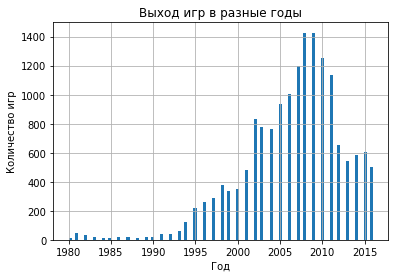

In [13]:
games['year_of_release'].plot(kind='hist', bins=100, grid = True)
plt.title('Выход игр в разные годы')
plt.xlabel('Год')
plt.ylabel('Количество игр')

**До 1995 года наблюдается "стабильность" выхода игр. После начался рост, смею предположить что за этим стоит выход в свет таких консолей как Playstation, DreamCast, Dendy, Sega и другие. Но начиная с 2011 начинается спад, возможно это связано с выходом игр на телефоны, а также поглощение и вытеснение с рынка "мелких пешек" такими гигантами как Sony, Microsoft. К тому же имеет место быть избирательности в аудитории.**

### 2.3 Суммарные продажи по платформам

Text(0, 0.5, 'Платформа')

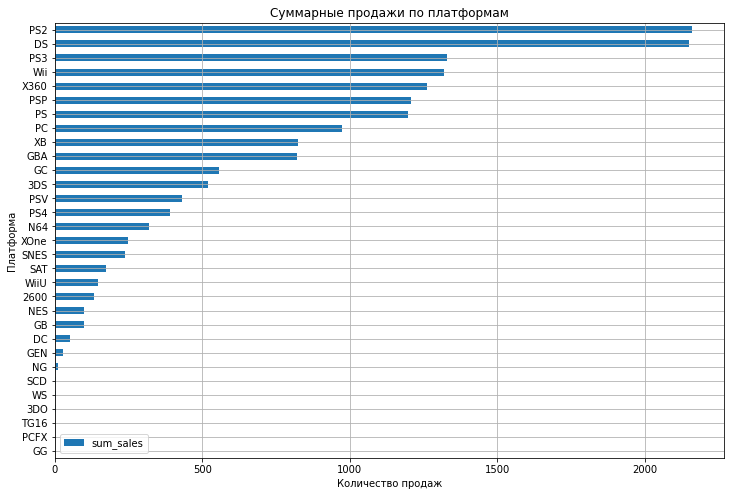

In [14]:
games_sal_pla = games.pivot_table(index = 'platform', values = 'sum_sales', aggfunc = 'count').sort_values(by='sum_sales', ascending = True)
games_sal_pla.plot(kind='barh', figsize = (12,8), grid = True)
plt.title('Суммарные продажи по платформам')
plt.xlabel('Количество продаж')
plt.ylabel('Платформа')

**В явных лидерах у нас PS2 и DS, за ними следуют PS3, Wii, X360, PSP и PS. Думаю по этим платформам можно построить распределение продаж по годам.**

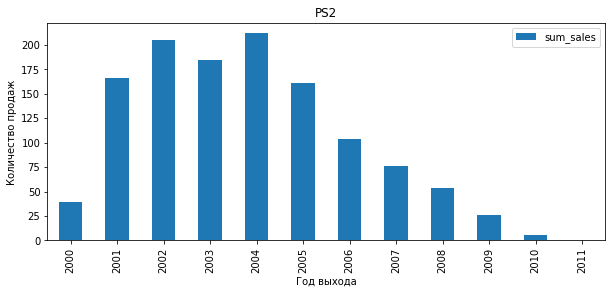

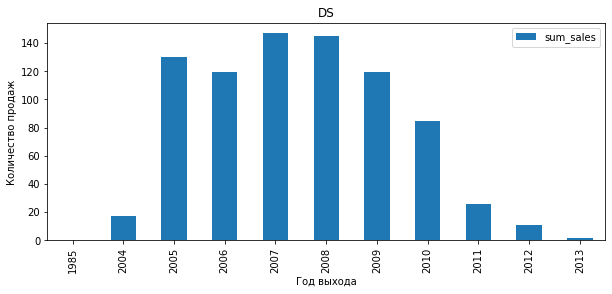

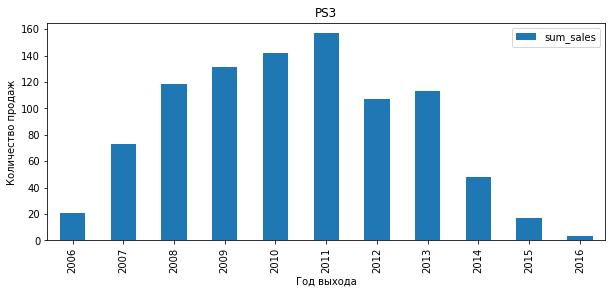

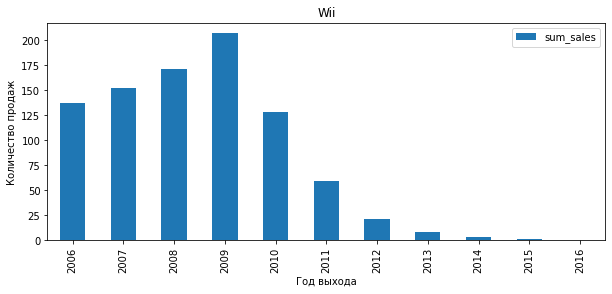

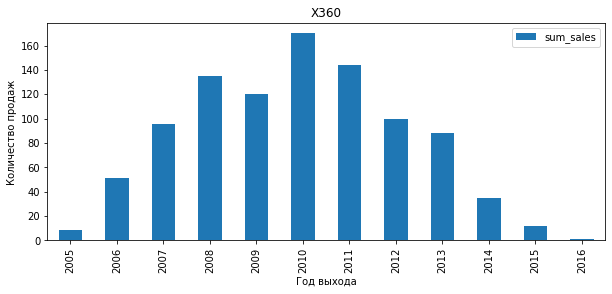

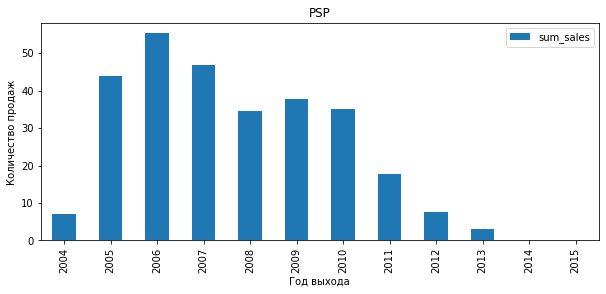

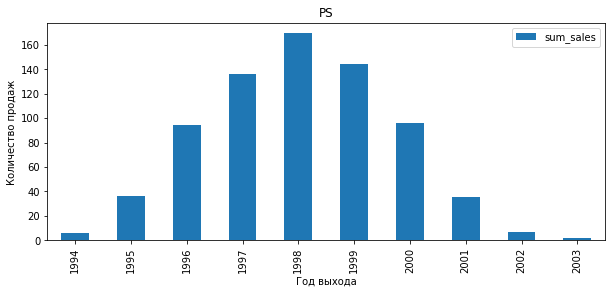

In [15]:
platform_list = ['PS2', 'DS', 'PS3', 'Wii', 'X360', 'PSP', 'PS'] #создадим список с выбранными нами платформами
for platform in platform_list:
    games[games['platform'] == platform].pivot_table(index='year_of_release', values='sum_sales', aggfunc='sum').plot(kind='bar', figsize=(10,4))
    plt.title(platform)
    plt.xlabel('Год выхода')
    plt.ylabel('Количество продаж')

**У каждой платформы пик продаж пришелся на разные годы. Из графиков можно предположить что платформа "цветет, дает плоды и увядает" в среднем на протяжении 10 лет.**

###  3.3 Определение периода для дальнейших исследований

### *У нас имеется необходимость в определении периода, который нужно выбрать для дальнейших исследований. Анализ данных этого периода должен помочь построить прогноз на 2017 год.*

*Есть предположение взять период, начиная с 2013 года, так как этот период небольшого, но роста в выпуске игр, после конечно идет спад. В планах попробовать выявить это "падение", дабы извлечь проблемы, которые мы можем избежать в прогнозе на 2017 год.*

In [16]:
forecast_2017 = games[games['year_of_release'] >= 2013]
forecast_2017

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sum_sales
16,Grand Theft Auto V,PS3,2013,Action,7.02,9.09,0.98,3.96,97.0,8.2,M,21.05
23,Grand Theft Auto V,X360,2013,Action,9.66,5.14,0.06,1.41,97.0,8.1,M,16.27
31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,NaN,0.0,NaN,14.63
33,Pokemon X/Pokemon Y,3DS,2013,Role-Playing,5.28,4.19,4.35,0.78,NaN,0.0,NaN,14.60
42,Grand Theft Auto V,PS4,2014,Action,3.96,6.31,0.38,1.97,97.0,8.3,M,12.62
...,...,...,...,...,...,...,...,...,...,...,...,...
16703,Strawberry Nauts,PSV,2016,Adventure,0.00,0.00,0.01,0.00,NaN,0.0,NaN,0.01
16707,Aiyoku no Eustia,PSV,2014,Misc,0.00,0.00,0.01,0.00,NaN,0.0,NaN,0.01
16710,Samurai Warriors: Sanada Maru,PS3,2016,Action,0.00,0.00,0.01,0.00,NaN,0.0,NaN,0.01
16712,Haitaka no Psychedelica,PSV,2016,Adventure,0.00,0.00,0.01,0.00,NaN,0.0,NaN,0.01


### 3.4 Выбор потенциально прибыльных платформ

In [17]:
for_2017 = forecast_2017.groupby('sum_sales')
for_2017.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sum_sales
16,Grand Theft Auto V,PS3,2013,Action,7.02,9.09,0.98,3.96,97.0,8.2,M,21.05
23,Grand Theft Auto V,X360,2013,Action,9.66,5.14,0.06,1.41,97.0,8.1,M,16.27
31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,NaN,0.0,NaN,14.63
33,Pokemon X/Pokemon Y,3DS,2013,Role-Playing,5.28,4.19,4.35,0.78,NaN,0.0,NaN,14.60
42,Grand Theft Auto V,PS4,2014,Action,3.96,6.31,0.38,1.97,97.0,8.3,M,12.62
...,...,...,...,...,...,...,...,...,...,...,...,...
15486,Arslan: The Warriors of Legend,XOne,2016,Action,0.01,0.00,0.00,0.00,NaN,5.8,T,0.01
15597,Ratchet & Clank Collection,PSV,2014,Action,0.00,0.01,0.00,0.00,NaN,0.0,NaN,0.01
15615,Disney Infinity,PSV,2013,Action,0.01,0.00,0.00,0.00,NaN,0.0,NaN,0.01
15734,Prototype: Biohazard Bundle,PS4,2016,Action,0.01,0.00,0.00,0.00,48.0,2.0,M,0.01


In [18]:
forecast_2017.groupby('platform')['sum_sales'].describe()

,count,mean,std,min,25%,50%,75%,max
platform,,,,,,,,
3DS,303.0,0.472772,1.381347,0.01,0.0400,0.090,0.2800,14.60
DS,8.0,0.192500,0.172026,0.03,0.0675,0.150,0.2525,0.51
PC,189.0,0.208624,0.352304,0.01,0.0300,0.080,0.2300,3.05
PS3,345.0,0.525884,1.451939,0.01,0.0400,0.150,0.5100,21.05
PS4,392.0,0.801378,1.609456,0.01,0.0600,0.200,0.7300,14.63
PSP,67.0,0.052239,0.059768,0.01,0.0150,0.020,0.0700,0.24
PSV,358.0,0.092151,0.153816,0.01,0.0200,0.040,0.1100,1.96
Wii,23.0,0.593913,0.915432,0.01,0.0450,0.180,0.7550,3.58
WiiU,115.0,0.562000,1.038778,0.01,0.0600,0.200,0.5950,7.09


**По продажам в лидерах PS3, дальше идут X360, PS4, 3DS, XOne. Так как PS4 и XOne относительно "молодые" платформы по сравнению с другими, то они считаются еще прибыльными. Остальные же "вянут" в связи с популяризацией и мировой рекламой таких брендов как Sony и Microsoft.**

 ### 3.5 Глобальные продажи игр в разбивке по платформам

Text(0, 0.5, 'Суммарные продажи')

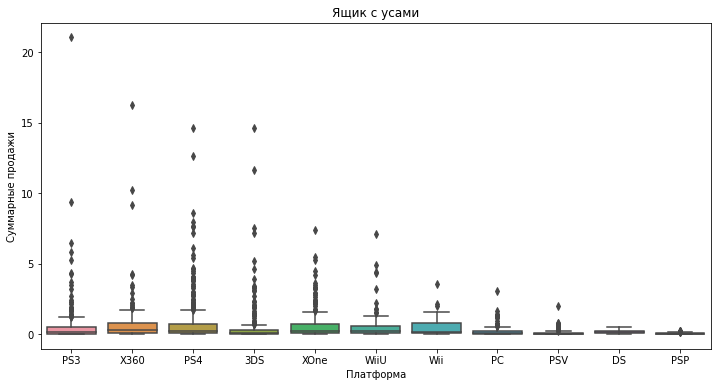

In [19]:
plt.figure(figsize=(12,6))
ylim=[0,2]
sns.boxplot(data=forecast_2017, x='platform', y='sum_sales')
plt.title('Ящик с усами')
plt.xlabel('Платформа')
plt.ylabel('Суммарные продажи')


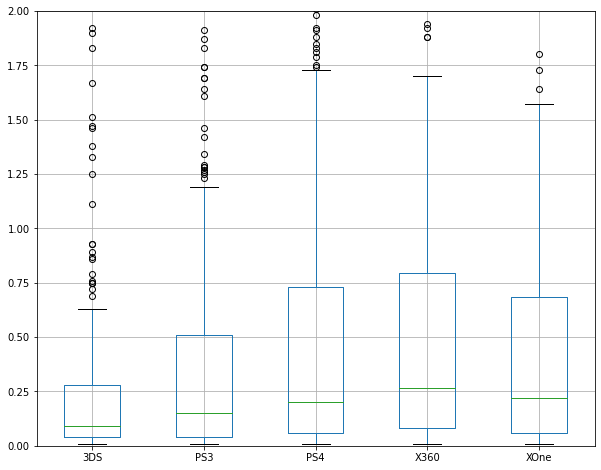

In [20]:
top_pl = ['PS3', 'X360', 'PS4', '3DS', 'XOne']
fig,ax = plt.subplots(figsize=(10,8))
forecast_2017.query('platform == @top_pl').pivot_table(values='sum_sales', index=['name'], columns='platform').boxplot(ax=ax, grid=True)
ax.set_ylim(0,2)
plt.show()

**Рассмотрю самые популярные на сей день платформы Xone и PS4. Среднее значение по суммарным продажам немного больше чем у явного лидера - PS4, наблюдается некая стабильность продаж нежели акцент на экслюзивы-хиты.**

**Выбросов достаточно - возможно очень популярные игры - хиты.**

**3DS замыкает этот топ**

### 3.6 Влияние отзывов пользователей и критиков на продажи внутри одной популярной платформы

In [21]:
#Возьмем популярную платформу PS4 и расситаем корреляцию оценки пользователей от продаж
ps_4 = games[games['platform']=='PS4']
ps_4['user_score'].corr(ps_4['sum_sales'])

0.10493810283090231

**Корреляция почти отсутствует.**

Text(0, 0.5, 'Суммарные продажи')

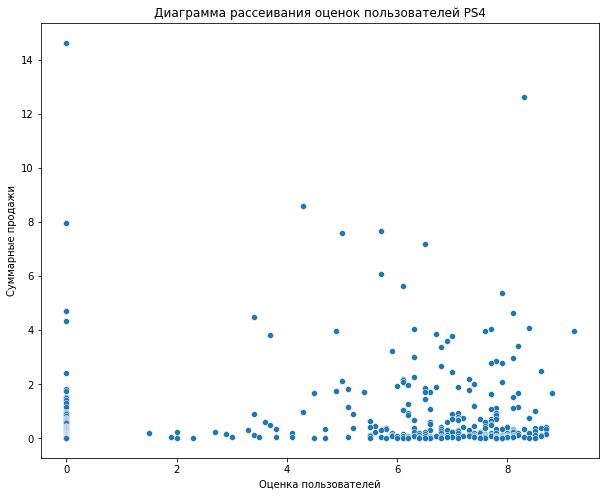

In [22]:
#Диаграмма рассеивания
plt.figure(figsize=(10,8))
sns.scatterplot(data=ps_4, x='user_score', y='sum_sales')
plt.title('Диаграмма рассеивания оценок пользователей PS4')
plt.xlabel('Оценка пользователей')
plt.ylabel('Суммарные продажи')

Text(0, 0.5, 'Суммарные продажи')

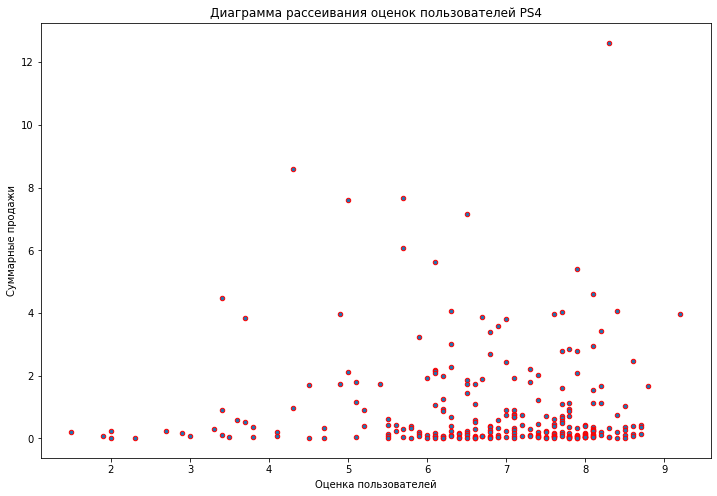

In [23]:
ps_4 = games[(games['platform'] == 'PS4') & (games['user_score'] > 0)].copy()
ps_4.plot(kind='scatter', x='user_score', y='sum_sales', ec='red', figsize=(12,8))
plt.title('Диаграмма рассеивания оценок пользователей PS4')
plt.xlabel('Оценка пользователей')
plt.ylabel('Суммарные продажи')

0.40589480145836687


Text(0, 0.5, 'Суммарные продажи')

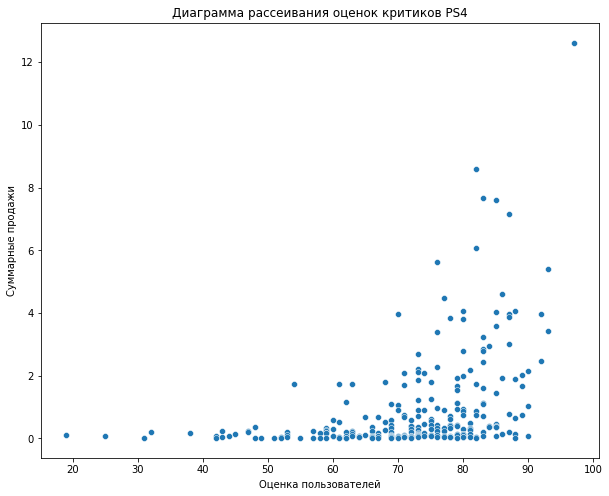

In [24]:
#То же и для оценок критиков
print(ps_4['critic_score'].corr(ps_4['sum_sales']))
plt.figure(figsize=(10,8))
sns.scatterplot(data=ps_4, x='critic_score', y='sum_sales')
plt.title('Диаграмма рассеивания оценок критиков PS4')
plt.xlabel('Оценка пользователей')
plt.ylabel('Суммарные продажи')

**У оценок критиков корреляция поближе к 1, а значит зависимость будет сильнее. Иными словами, их оценки предпочтительнее.**  

*Теперь посмотрим что у наиближайшего конкурента в лице Xone.*

0.0802618590461051


Text(0, 0.5, 'Суммарные продажи')

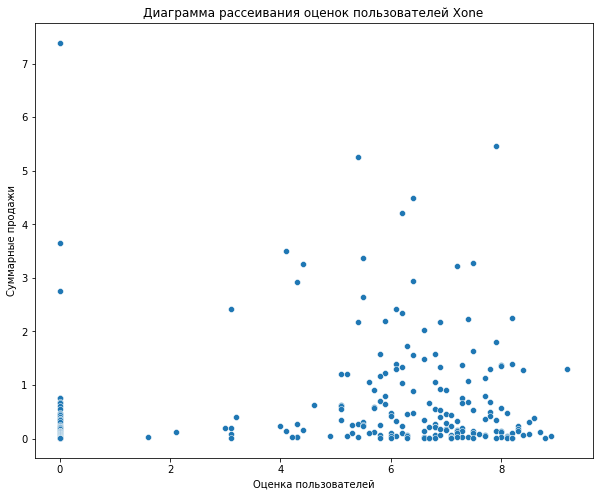

In [25]:
x_one = games[games['platform']=='XOne']

print(x_one['user_score'].corr(x_one['sum_sales']))
plt.figure(figsize=(10,8))
sns.scatterplot(data=x_one, x='user_score', y='sum_sales')
plt.title('Диаграмма рассеивания оценок пользователей Xone')
plt.xlabel('Оценка пользователей')
plt.ylabel('Суммарные продажи')

Text(0, 0.5, 'Суммарные продажи')

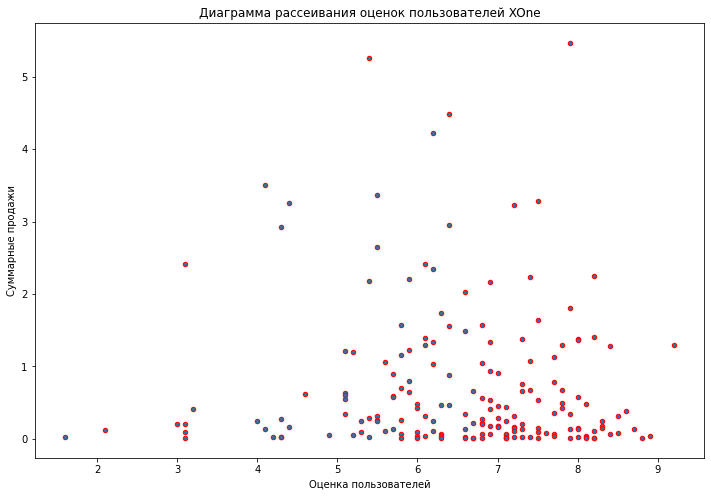

In [26]:
x_one = games[(games['platform'] == 'XOne') & (games['user_score'] > 0)].copy()
x_one.plot(kind='scatter', x='user_score', y='sum_sales', ec='red', figsize=(12,8))
plt.title('Диаграмма рассеивания оценок пользователей XOne')
plt.xlabel('Оценка пользователей')
plt.ylabel('Суммарные продажи')

0.41042203561296375


Text(0, 0.5, 'Суммарные продажи')

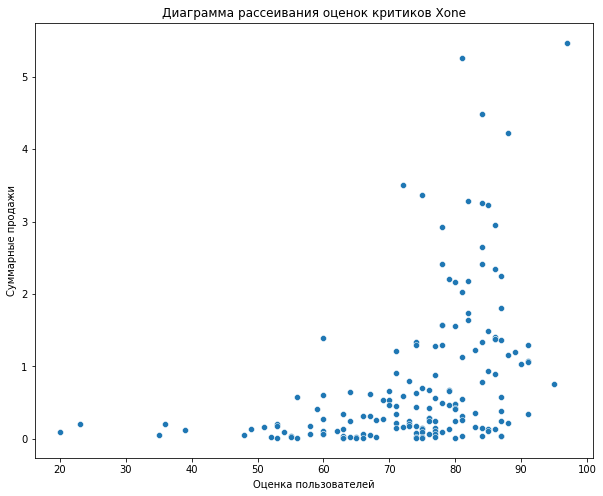

In [27]:
print(x_one['critic_score'].corr(x_one['sum_sales']))
plt.figure(figsize=(10,8))
sns.scatterplot(data=x_one, x='critic_score', y='sum_sales')
plt.title('Диаграмма рассеивания оценок критиков Xone')
plt.xlabel('Оценка пользователей')
plt.ylabel('Суммарные продажи')

0.18341013061262493
0.3937358653072584


Text(0, 0.5, 'Суммарные продажи')

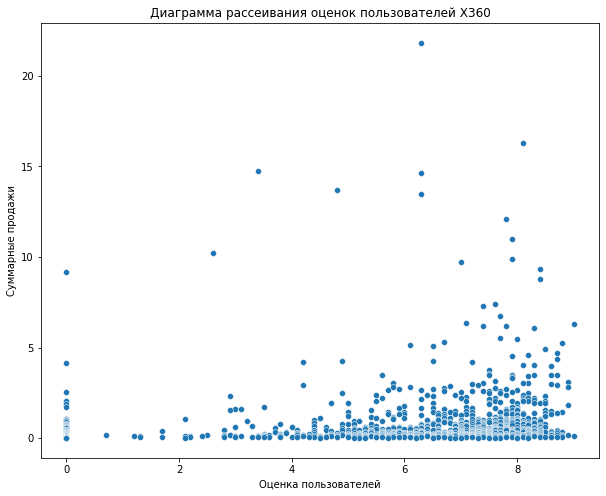

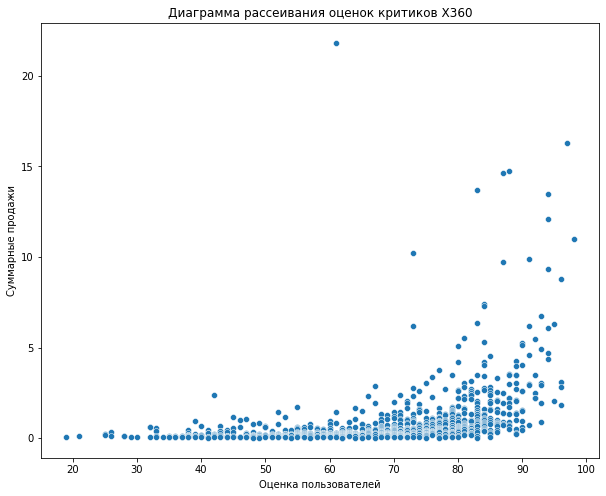

In [28]:
#Для X360
x_360 = games[games['platform']=='X360']

print(x_360['user_score'].corr(x_360['sum_sales']))
plt.figure(figsize=(10,8))
sns.scatterplot(data=x_360, x='user_score', y='sum_sales')
plt.title('Диаграмма рассеивания оценок пользователей X360')
plt.xlabel('Оценка пользователей')
plt.ylabel('Суммарные продажи')

print(x_360['critic_score'].corr(x_360['sum_sales']))
plt.figure(figsize=(10,8))
sns.scatterplot(data=x_360, x='critic_score', y='sum_sales')
plt.title('Диаграмма рассеивания оценок критиков X360')
plt.xlabel('Оценка пользователей')
plt.ylabel('Суммарные продажи')

Text(0, 0.5, 'Суммарные продажи')

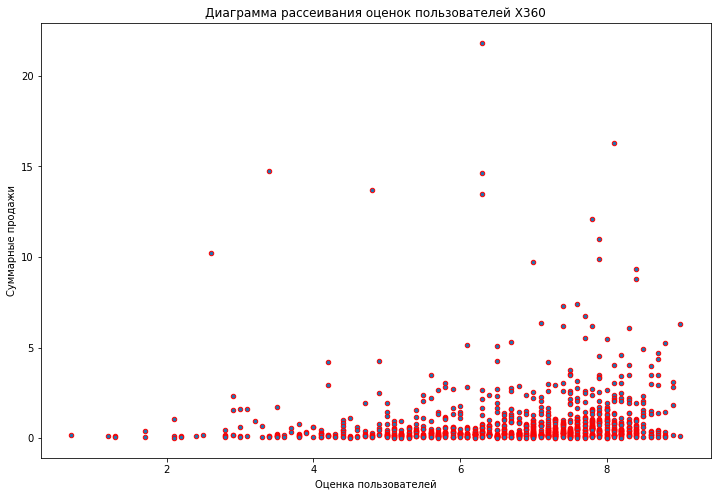

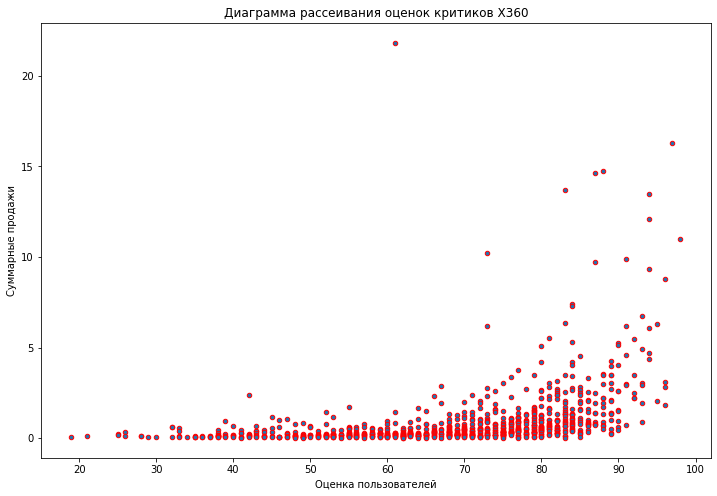

In [29]:
x_360 = games[(games['platform'] == 'X360') & (games['user_score'] > 0)].copy()
x_360.plot(kind='scatter', x='user_score', y='sum_sales', ec='red', figsize=(12,8))
plt.title('Диаграмма рассеивания оценок пользователей X360')
plt.xlabel('Оценка пользователей')
plt.ylabel('Суммарные продажи')

x_360 = games[(games['platform'] == 'X360') & (games['critic_score'] > 0)].copy()
x_360.plot(kind='scatter', x='critic_score', y='sum_sales', ec='red', figsize=(12,8))
plt.title('Диаграмма рассеивания оценок критиков X360')
plt.xlabel('Оценка пользователей')
plt.ylabel('Суммарные продажи')

0.2526255237270719
0.43337268693947595


Text(0, 0.5, 'Суммарные продажи')

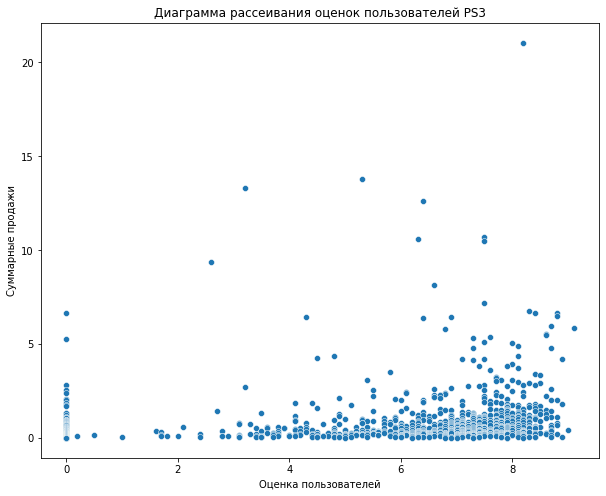

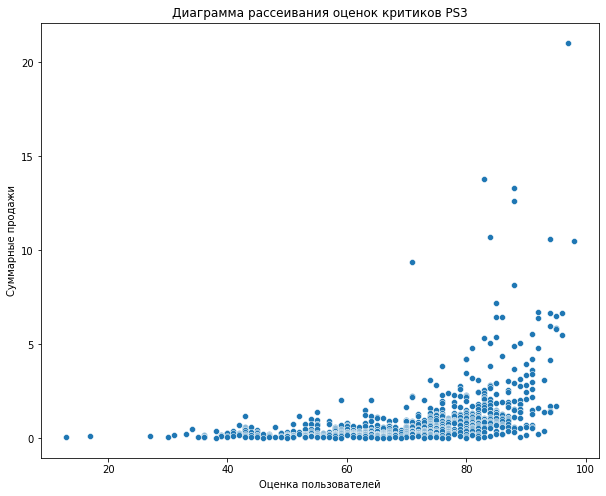

In [30]:
#Для PS3
ps_3 = games[games['platform']=='PS3']

print(ps_3['user_score'].corr(ps_3['sum_sales']))
plt.figure(figsize=(10,8))
sns.scatterplot(data=ps_3, x='user_score', y='sum_sales')
plt.title('Диаграмма рассеивания оценок пользователей PS3')
plt.xlabel('Оценка пользователей')
plt.ylabel('Суммарные продажи')

print(ps_3['critic_score'].corr(ps_3['sum_sales']))
plt.figure(figsize=(10,8))
sns.scatterplot(data=ps_3, x='critic_score', y='sum_sales')
plt.title('Диаграмма рассеивания оценок критиков PS3')
plt.xlabel('Оценка пользователей')
plt.ylabel('Суммарные продажи')

Text(0, 0.5, 'Суммарные продажи')

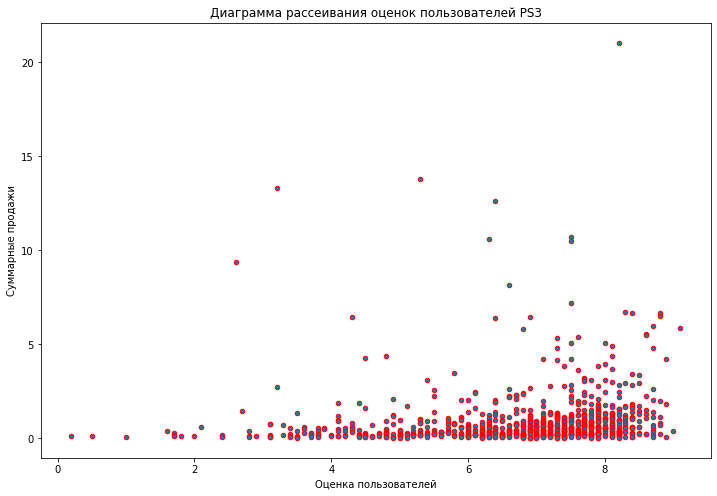

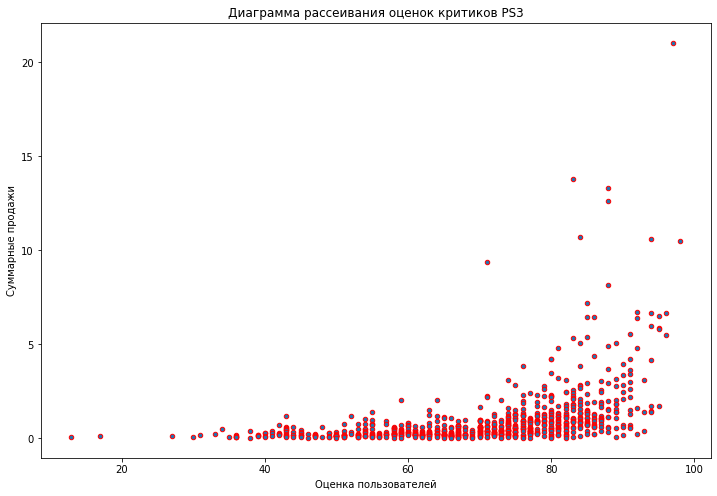

In [31]:
ps_3 = games[(games['platform'] == 'PS3') & (games['user_score'] > 0)].copy()
ps_3.plot(kind='scatter', x='user_score', y='sum_sales', ec='red', figsize=(12,8))
plt.title('Диаграмма рассеивания оценок пользователей PS3')
plt.xlabel('Оценка пользователей')
plt.ylabel('Суммарные продажи')

ps_3 = games[(games['platform'] == 'PS3') & (games['critic_score'] > 0)].copy()
ps_3.plot(kind='scatter', x='critic_score', y='sum_sales', ec='red', figsize=(12,8))
plt.title('Диаграмма рассеивания оценок критиков PS3')
plt.xlabel('Оценка пользователей')
plt.ylabel('Суммарные продажи')

**Мини-вывод: оценки критиков больше влияют на суммарные продажи. Это, естественно, выгодно для компаний-разработчиков, так как лучше им оставит отзыв крупная компания и сделает рекламу нежели какой-то обычный среднестатистический пользователь оставит отзыв на неизвестном форуме.**  

### 3.7 Общее распределение игр по жанрам

In [32]:
genres = forecast_2017.pivot_table(index='genre', values='sum_sales', aggfunc='sum').sort_values(by='sum_sales', ascending=False)
genres

,sum_sales
genre,
Action,321.87
Shooter,232.98
Sports,150.65
Role-Playing,145.89
Misc,62.82
Platform,42.63
Racing,39.89
Fighting,35.31
Adventure,23.64


*Самый прибыльный жанр, ушедший в отрыв, это Action. С самыми низкими продажами - Puzzle.*

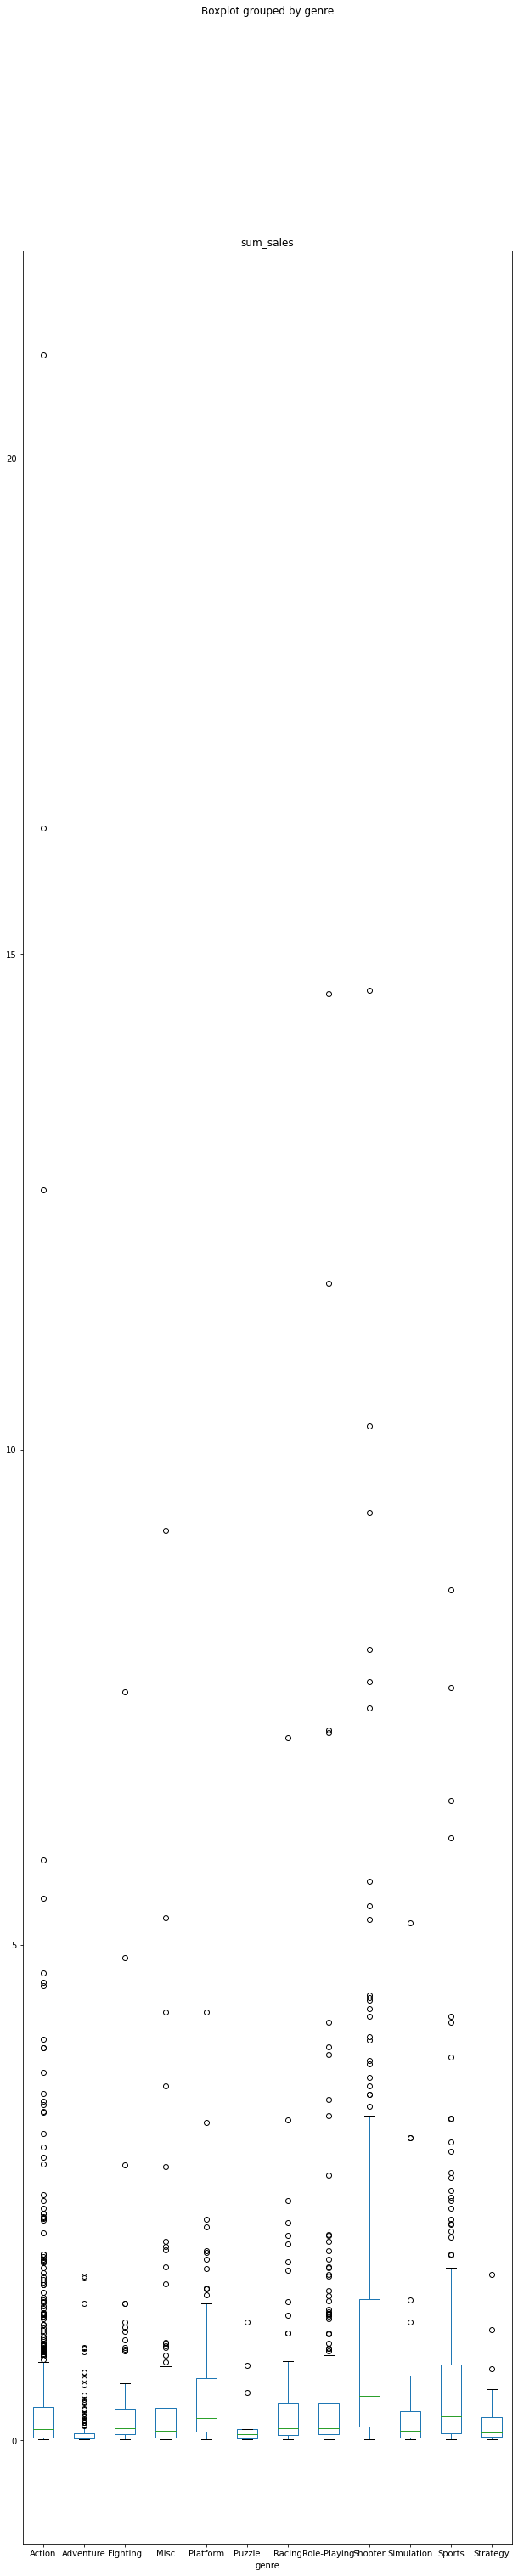

In [33]:
forecast_2017.boxplot(column=['sum_sales'], by='genre', grid=False, figsize=(10,50))
ylim = [0,2]
plt.show()

*Судя по "ящику с усами" можно выделить жанр Shooter, среднее больше остальных, считаю его самым прибыльным. К "аутсайдерам" бы отнес Adventure и Puzzle. Достаточно много выбросов.

***Что мы выяснили из исследовательского анализа данных:***

1. До 1995 года наблюдается "стабильность" выхода игр. После начался рост. Начиная с 2011 начинается спад.
2. PS2, DS, PS3, Wii, X360, PSP и PS - самые популярные платформы по количеству продаж за весь период. 
3. У каждой платформы пик продаж пришелся на разные годы. Платформа "живет" в среднем на протяжении 10 лет.
4. За рассматриваемый нами отрезок времени, а именно начиная с 2013 года, самыми популярными оказались PS3, X360, PS4, 3DS, XOne.
5. Оценки критиков больше влияют на суммарные продажи, нежели оценки пользователей. 
6. Самый прибыльный жанр - Shooter. Замыкает - Puzzle и Adventure.

# 4. Портрет пользователя каждого региона

### 4.1 Северная Америка.

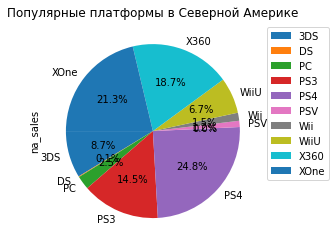

In [34]:
forecast_2017.groupby(['platform']).sum().plot(kind='pie', y='na_sales', autopct='%1.1f%%', startangle=180)
plt.title('Популярные платформы в Северной Америке')
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))

**Топ-5 популярных платформ: PS4, XOne, X360, PS3, 3DS.**

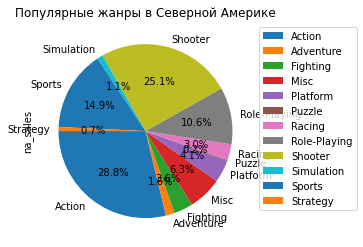

In [35]:
forecast_2017.groupby(['genre']).sum().plot(kind='pie', y='na_sales', autopct='%1.1f%%', startangle=180)
plt.title('Популярные жанры в Северной Америке')
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))

**Топ-5 популярных жанров: Action, Shooter, Sports, Role-Playing, Misc.**

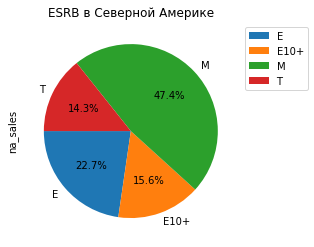

In [36]:
forecast_2017.groupby(['rating']).sum().plot(kind='pie', y='na_sales', autopct='%1.1f%%', startangle=180)
plt.title('ESRB в Северной Америке')
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))

**M, E, E10+, T**

### 4.2 Европа.

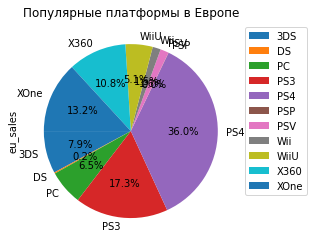

In [37]:
forecast_2017.groupby(['platform']).sum().plot(kind='pie', y='eu_sales', autopct='%1.1f%%', startangle=180)
plt.title('Популярные платформы в Европе')
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))

**Топ-5 популярных платформ: PS4, PS3, XOne, X360, 3DS.**

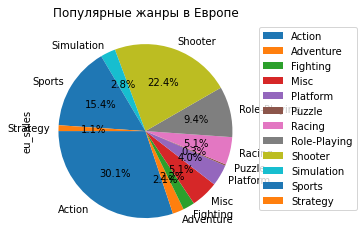

In [38]:
forecast_2017.groupby(['genre']).sum().plot(kind='pie', y='eu_sales', autopct='%1.1f%%', startangle=180)
plt.title('Популярные жанры в Европе')
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))

**Топ-5 популярных жанров: Action, Shooter, Sports, Role-Playing, Misc.**

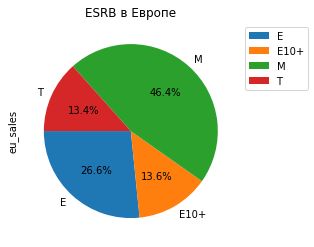

In [39]:
forecast_2017.groupby(['rating']).sum().plot(kind='pie', y='eu_sales', autopct='%1.1f%%', startangle=180)
plt.title('ESRB в Европе')
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))

**M, E, E10+, T**

### 4.3 Япония.

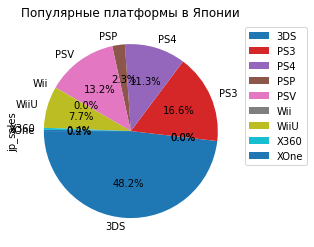

In [40]:
forecast_2017.groupby(['platform']).sum().plot(kind='pie', y='jp_sales', autopct='%1.1f%%', startangle=180)
plt.title('Популярные платформы в Японии')
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))

**Топ-5 популярных платформ: 3DS, PS3, PSV, PS4, WiiU.**

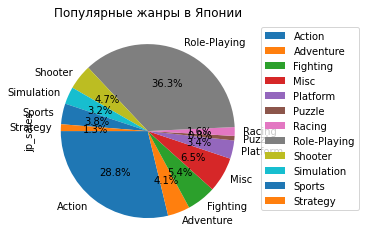

In [41]:
forecast_2017.groupby(['genre']).sum().plot(kind='pie', y='jp_sales', autopct='%1.1f%%', startangle=180)
plt.title('Популярные жанры в Японии')
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))

**Топ-5 популярных жанров: Role-Playing, Action, Misc, Fighting, Shooter.**

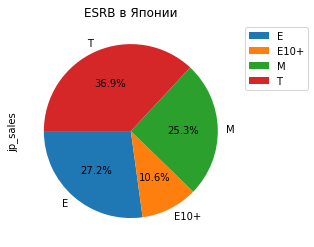

In [42]:
forecast_2017.groupby(['rating']).sum().plot(kind='pie', y='jp_sales', autopct='%1.1f%%', startangle=180)
plt.title('ESRB в Японии')
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))

**T, E, M, E10+**

### 4.4 Другие страны.

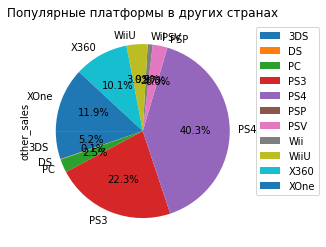

In [43]:
forecast_2017.groupby(['platform']).sum().plot(kind='pie', y='other_sales', autopct='%1.1f%%', startangle=180)
plt.title('Популярные платформы в других странах')
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))

**Топ-5 популярных платформ: PS4, PS3, XOne, X360, 3DS.**

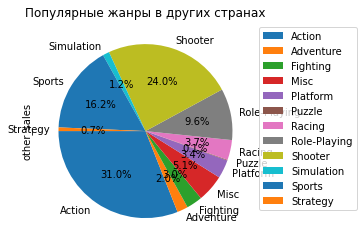

In [44]:
forecast_2017.groupby(['genre']).sum().plot(kind='pie', y='other_sales', autopct='%1.1f%%', startangle=180)
plt.title('Популярные жанры в других странах')
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))

**Топ-5 популярных жанров: Action, Shoter, Sports, Role-Playing, Misc.**

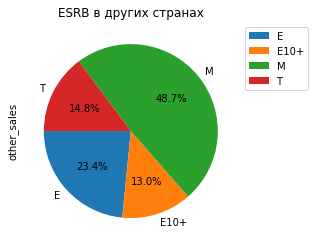

In [45]:
forecast_2017.groupby(['rating']).sum().plot(kind='pie', y='other_sales', autopct='%1.1f%%', startangle=180)
plt.title('ESRB в других странах')
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))

**M, E, T, E10+**

**Краткий вывод:**
1. Америка:
- популярные платформы: PS4, XOne, X360, PS3, 3DS
- популярные жанры: Action, Shooter, Sports, Role-Playing, Misc
- по рейтингам: M, E, E10+, T
2. Европа:
- популярные платформы: PS4, PS3, XOne, X360, 3DS
- популярные жанры: Action, Shooter, Sports, Role-Playing, Misc
- по рейтингам: M, E, E10+, T
3. Япония:
- популярные платформы: 3DS, PS3, PSV, PS4, WiiU
- популярные жанры: Role-Playing, Action, Misc, Fighting, Shooter
- по рейтингам: T, E, M, E10+
4. Другие страны:
- популярные платформы: PS4, PS3, XOne, X360, 3DS
- популярные жанры: Action, Shoter, Sports, Role-Playing, Misc
- по рейтингам: M, E, T, E10+

В Америке, Европе и других странах наблюдается абсолютная схожесть по "топам". Рейтинги показывают что игры направлены на категорию М(зрелые 17+), а после уже идет Е(для всех).
Что не скажешь о Японии, у которой платформы все с внутреннего рынка, жанры схожи, но предпочтение отдают Role-Playing. По рейтингам преобладает категория Т(для подростков), а после Е(для всех).  

# 5. Проверка гипотез

### 5.1 Средние пользовательские рейтинги платформ Xbox One и PC одинаковые

Нулевая гипотеза: средние пользовательские рейтинги платформ Xbox One и PC одинаковые

Альтернативная: средние пользовательские рейтинги платформ Xbox One и PC не одинаковые

In [46]:
#Нам нужны две выборки
pc = forecast_2017[(forecast_2017['platform'] == 'PC') & (forecast_2017['user_score'] >= 0)]['user_score']
xone = forecast_2017[(forecast_2017['platform'] == 'XOne') & (forecast_2017['user_score'] >= 0)]['user_score']
#Посмотрим на количество значений через .shape[]
print(pc.shape[0])
xone.shape[0]

184


236

In [47]:
alpha = 0.05 #уровень значимости зададим 0.05
results = st.ttest_ind(pc, xone, equal_var = False) #False, так как выборки разные
print('p-значение:', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 0.3746140005667862
Не получилось отвергнуть нулевую гипотезу


In [48]:
#Проверим средние значения
print(pc.mean())
print(xone.mean())

5.281521739130435
5.029237288135594


**Проверка гипотезы дала нам ответ, что средние пользовательские рейтинги платформ Xbox One и PC не одинаковые, но в целом близкие по среднему значению**

### 5.2 Средние пользовательские рейтинги жанров Action и Sports разные.

Нулевая гипотеза: средние пользовательские рейтинги жанров Action и Sports разные

Альтернативная: средние пользовательские рейтинги жанров Action и Sports одинаковые

In [49]:
action = forecast_2017[(forecast_2017['genre'] == 'Action') & (forecast_2017['user_score'] > 0)]['user_score']
sports = forecast_2017[(forecast_2017['genre'] == 'Sports') & (forecast_2017['user_score'] > 0)]['user_score']
print(action.shape[0])
sports.shape[0]

389


160

In [176]:
alpha = 0.05 #уровень значимости зададим 0.05
results = st.ttest_ind(action, sports, equal_var = False) #False, так как выборки разные
print('p-значение:', results.pvalue)
if results.pvalue < alpha:
    print('Не отвергаем нулевую гипотезу')
else:
    print('Отвергаем нулевую гипотезу')

p-значение: 1.4460039700704315e-20
Не отвергаем нулевую гипотезу


In [51]:
print(action.mean())
print(sports.mean())

6.837532133676092
5.238124999999999


**Проверка гипотезы дала нам ответ, что средние пользовательские рейтинги жанров Action и Sports разные.**

# 6. Общий вывод

Нами был изучен датасет *games*, в котором были исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы.

 - В предобработке данных мы привели столбцы датасета к "нижнему" регистру, изменили типы данных, обработали пропуски, создали новый столбец с суммарными продажами во всех регионах, проверили на дубликаты.

 
 - Что мы выяснили из исследовательского анализа данных:

1. До 1995 года наблюдается "стабильность" выхода игр. После начался рост. Начиная с 2011 начинается спад.
2. PS2, DS, PS3, Wii, X360, PSP и PS - самые популярные платформы по количеству продаж за весь период. 
3. У каждой платформы пик продаж пришелся на разные годы. Платформа "живет" в среднем на протяжении 10 лет.
4. За рассматриваемый нами отрезок времени, а именно начиная с 2013 года, самыми популярными оказались PS4, XOne, X360, PS3 и WiiU.
5. Оценки критиков больше влияют на суммарные продажи, нежели оценки пользователей. 
6. Самый прибыльный жанр - Shooter. Замыкает - Puzzle и Adventure.

 - Составили пользовательские портреты стран

 Америка:
- популярные платформы: PS4, XOne, X360, PS3, 3DS
- популярные жанры: Action, Shooter, Sports, Role-Playing, Misc
- по рейтингам: M, E, E10+, T
 
 Европа:
- популярные платформы: PS4, PS3, XOne, X360, 3DS
- популярные жанры: Action, Shooter, Sports, Role-Playing, Misc
- по рейтингам: M, E, E10+, T
 
 Япония:
- популярные платформы: 3DS, PS3, PSV, PS4, WiiU
- популярные жанры: Role-Playing, Action, Misc, Fighting, Shooter
- по рейтингам: T, E, M, E10+
 
 Другие страны:
- популярные платформы: PS4, PS3, XOne, X360, 3DS
- популярные жанры: Action, Shoter, Sports, Role-Playing, Misc
- по рейтингам: M, E, T, E10+

где узнали что
В Америке, Европе и других странах наблюдается абсолютная схожесть по "топам". Рейтинги показывают что игры направлены на категорию М(зрелые 17+), а после уже идет Е(для всех).
Что не скажешь о Японии, у которой платформы все с внутреннего рынка, жанры схожи, но предпочтение отдают Role-Playing. По рейтингам преобладает категория Т(для подростков), а после Е(для всех).  

Также проверили некоторые гипотезы, а именно:

 - что средние пользовательские рейтинги платформ Xbox One и PC почти равны
 
 - что средние пользовательские рейтинги жанров Action и Sports разные